# To train up a Model with the .wav dataset. Run through this Notebook

In [ ]:
#Download Dataset
!wget https://zenodo.org/record/4682101/files/dataset.zip

--2021-04-15 08:59:07--  https://zenodo.org/record/4682101/files/dataset.zip
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2496387986 (2.3G) [application/octet-stream]
Saving to: ‘dataset.zip’

dataset.zip           9%[>                   ] 234.03M  3.02MB/s    eta 13m 59s

In [2]:
#Unzip Dataset
!unzip dataset.zip > 0

In [1]:
# import Required Libraries
from matplotlib import cm
import os.path
import random
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import tensorflow.compat.v1.keras.backend as K
from feature_extract import *
from train import Model
from tflite_op import *
from feature_extract import *

if tf.test.is_built_with_cuda():
    from tensorflow.compat.v1 import ConfigProto
    from tensorflow.compat.v1 import InteractiveSession
    config = ConfigProto()
    config.gpu_options.allow_growth = True
    sess = InteractiveSession(config=config)
else:
    sess = InteractiveSession()

In [2]:
#!unzip dataset.zip > 0
""" 
    Read Samples directory into an Array Excluding irrelivant directories
"""
data_dir = pathlib.Path('dataset')

commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'validation_list.txt']
commands = commands[commands != "_background_noise_"]
commands = commands[commands != 'LICENSE']
commands = commands[commands != '.DS_Store']
commands = commands[commands != 'README.md']
commands = commands[commands != 'testing_list.txt']
commands = commands[commands != '.ipynb_checkpoints']
# commands = commands[commands != 'silence']
commands = list(commands)
print("Number of Commands: ", len(commands))

Number of Commands:  39


In [3]:
!rm -r dataset/_background_noise_
# !rm -r dataset/silence
model_dir = pathlib.Path('checkpoints')

# We are creating a List of the Words that you want to tarin the Model. Please leave the Silence and the Unknown Index as they are

In [4]:
training_commands = ["silence", "unknown", "on", "off", "fan", "heater", "light"] # Enter Your Required Labels for Training

In [5]:
training_percent = 0.7 # Percentage of Data available for Training
validation_percent = 0.20 # Percentage of Data available for Validation
testing_percent = 0.10 # Percentage of Data available for Testing

In [6]:
train_files = []
val_files = []
test_files= []
unknown = []
high = 0

for com in commands:
    search_path = os.path.join(data_dir, com, '*.wav')
    files = gfile.Glob(search_path)
    if com in training_commands:
        n_of_samples = len(files)
        if n_of_samples >= high:
            high = n_of_samples
        train_percent = int(n_of_samples * training_percent) # Percentage of Data available for Training
        val_percent = int(n_of_samples*validation_percent) # Percentage of Data available for Validation
        test_percent = int(n_of_samples*testing_percent) # Percentage of Data available for Testitraining_percent
        print(com, n_of_samples)
        train_files += files[:train_percent]
        val_files += files[train_percent:val_percent+train_percent]
        test_files += files[val_percent+train_percent:]
    else:
        unknown += files

np.random.shuffle(unknown)      
unknown = unknown[:high]
n_of_samples = len(unknown)
train_percent = int(n_of_samples * training_percent) # Percentage of Data available for Training
val_percent = int(n_of_samples*validation_percent) # Percentage of Data available for Validation
test_percent = int(n_of_samples*testing_percent) # Percentage of Data available for Testitraining_percent
train_files += files[:train_percent]
val_files += files[train_percent:val_percent+train_percent]
test_files += files[val_percent+train_percent:]
        
print("unknown", len(unknown))

silence 75
fan 332
heater 332
off 3958
light 351
on 4071
unknown 4071


In [7]:
print("training samples: ", len(train_files))
print("validation Samples: ", len(val_files))
print("test Samples: ", len(test_files))

training samples:  8493
validation Samples:  1822
test Samples:  917


## Create Model and Model Layers. You can increase the CNN filters to desired values to increase accuracy

In [8]:
model = Model(first_conv_filter = 8, model_dir="checkpoints", commands= training_commands , sess = sess) # Create Model

{0: 'silence', 1: 'unknown', 2: 'on', 3: 'off', 4: 'fan', 5: 'heater', 6: 'light'}


In [10]:
#Comment out to load from checkpoint, you can also pass in path to checkpoint
#model.load_checkpoint()
#model.load_checkpoint(path="checkpoint/model_checkpoint.ckpt-15000") 

In [9]:
# Train Model
history = model.train(learn_rate=[0.001, 0.0001], dropout_rate=0.5, save_step=1000, eval_step=1000,
                      batch_size=256, training_time=15000, rate_step=10000, display_step=1000, 
                      train_data=train_files, Validation_data=val_files)

INFO:tensorflow:Using MirroredStrategy with devices ('/replica:0/task:0/device:GPU:0', '/replica:0/task:0/device:GPU:1')
Step #0: learning rate 0.001000, accuracy 5.5%, cross entropy 2.155438
Step 0: Validation accuracy = 40.0% (Val Size=1024), Validation loss = 1.859394
Step #1000: learning rate 0.001000, accuracy 77.7%, cross entropy 0.613008
Step 1000: Validation accuracy = 77.3% (Val Size=1024), Validation loss = 0.674524
Step #2000: learning rate 0.001000, accuracy 84.4%, cross entropy 0.541491
Step 2000: Validation accuracy = 77.6% (Val Size=1024), Validation loss = 0.603156
Step #3000: learning rate 0.001000, accuracy 86.3%, cross entropy 0.405746
Step 3000: Validation accuracy = 83.4% (Val Size=1024), Validation loss = 0.485173
Step #4000: learning rate 0.001000, accuracy 85.9%, cross entropy 0.388513
Step 4000: Validation accuracy = 83.8% (Val Size=1024), Validation loss = 0.476771
Step #5000: learning rate 0.001000, accuracy 85.5%, cross entropy 0.475024
Step 5000: Validation

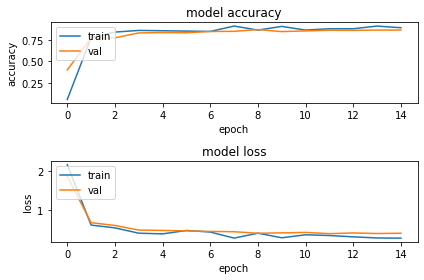

In [11]:
plt.subplot(211)
plt.plot(history['categorical_accuracy'])
plt.plot(history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')# summarize history for loss 



plt.subplot(212)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')
plt.tight_layout()
plt.show()

In [12]:
data, label = model.get_next_batch(200, file_path = test_files) # Grab 2000 files from Test files for Evaluation

In [13]:
len(data[0])

1960

In [14]:
model.evaluate(data, label) # Evaluate on Data # Please note 

Validation accuracy = 85.5%, Validation loss = 0.431981


(0.855, 0.43198094)

# Let us See the Accuracy on Test Samples

In [15]:
grab = int(len(test_files)/5)
fro = 0
correct = 0
for i in range(5):
    data, label = model.get_next_batch(int(len(test_files)/5), test_files[fro:grab])
    predictions = model.predict(data)[0]
    correct+=np.sum(predictions == label)
    fro = grab
    grab+=int(len(test_files)/5)
print(' Model accuracy is %f%% (Number of test samples=%d)' % (
        (correct * 100) / len(test_files), len(test_files)))

 Model accuracy is 85.714286% (Number of test samples=917)


# Here we are Saving the Model for a reload using tf.saved_model.load, Serving Signature is set to Default

In [16]:
model.save_pb_model(file_name = "Model/model_pb",  first_conv_filter= 8, frequency_size=40, time_size=49, )

INFO:tensorflow:Restoring parameters from checkpoints/model_checkpoint.ckpt-15000
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: Model/model_pb/saved_model.pb


# The Next Lines of code introduces you to TensorFlow LITE (TFLITE) and Tensorflow LITE MICRO (TFLITE MICRO)
### TFLITE for Android Devices and Micro-Computers
### TFLITE Micro for Micro-controllers and Embedded Devices with low power and generally requiring int8 computations

In [17]:
# directories and tflite micro libraries
from tflite_op import *
rep_size = 100
float_model_tflite="Model/tfFloat"
quant_model_tflite= "Model/tflite"
pb_model_dir = "Model/model_pb"
tflite_micro = "Model/tflite_micro.cc"

In [18]:
# See tflite_op for implementation. Save TFLITE MODEL FOR FLOAT VALUE COMPUTATION
save_float_model(model_path=pb_model_dir, save_path=float_model_tflite)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.


INFO:tensorflow:Restoring parameters from Model/model_pb/variables/variables


INFO:tensorflow:Restoring parameters from Model/model_pb/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input


INFO:tensorflow: tensor name: Reshape_4:0, shape: (1, 1960), type: DT_FLOAT


INFO:tensorflow: tensor name: Reshape_4:0, shape: (1, 1960), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: output


INFO:tensorflow:Tensor's key in saved_model's tensor_map: output


INFO:tensorflow: tensor name: labels_softmax:0, shape: (1, 7), type: DT_FLOAT


INFO:tensorflow: tensor name: labels_softmax:0, shape: (1, 7), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from Model/model_pb/variables/variables


INFO:tensorflow:Restoring parameters from Model/model_pb/variables/variables


Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`


Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


INFO:tensorflow:Restoring parameters from Model/model_pb/variables/variables


INFO:tensorflow:Restoring parameters from Model/model_pb/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input


INFO:tensorflow: tensor name: Reshape_4:0, shape: (1, 1960), type: DT_FLOAT


INFO:tensorflow: tensor name: Reshape_4:0, shape: (1, 1960), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: output


INFO:tensorflow:Tensor's key in saved_model's tensor_map: output


INFO:tensorflow: tensor name: labels_softmax:0, shape: (1, 7), type: DT_FLOAT


INFO:tensorflow: tensor name: labels_softmax:0, shape: (1, 7), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from Model/model_pb/variables/variables


INFO:tensorflow:Restoring parameters from Model/model_pb/variables/variables


Float model is 116224 bytes


In [19]:
# # See tflite_op for implementation. Save TFLITE MODEL FOR INT8 VALUE COMPUTATION
save_quantized_model(model_path=pb_model_dir, save_path=quant_model_tflite, rep_files=train_files, rep_data=100)

INFO:tensorflow:Restoring parameters from Model/model_pb/variables/variables


INFO:tensorflow:Restoring parameters from Model/model_pb/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input


INFO:tensorflow: tensor name: Reshape_4:0, shape: (1, 1960), type: DT_FLOAT


INFO:tensorflow: tensor name: Reshape_4:0, shape: (1, 1960), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: output


INFO:tensorflow:Tensor's key in saved_model's tensor_map: output


INFO:tensorflow: tensor name: labels_softmax:0, shape: (1, 7), type: DT_FLOAT


INFO:tensorflow: tensor name: labels_softmax:0, shape: (1, 7), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from Model/model_pb/variables/variables


INFO:tensorflow:Restoring parameters from Model/model_pb/variables/variables


INFO:tensorflow:Restoring parameters from Model/model_pb/variables/variables


INFO:tensorflow:Restoring parameters from Model/model_pb/variables/variables


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default'}


INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default'}


INFO:tensorflow:input tensors info: 


INFO:tensorflow:input tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input


INFO:tensorflow:Tensor's key in saved_model's tensor_map: input


INFO:tensorflow: tensor name: Reshape_4:0, shape: (1, 1960), type: DT_FLOAT


INFO:tensorflow: tensor name: Reshape_4:0, shape: (1, 1960), type: DT_FLOAT


INFO:tensorflow:output tensors info: 


INFO:tensorflow:output tensors info: 


INFO:tensorflow:Tensor's key in saved_model's tensor_map: output


INFO:tensorflow:Tensor's key in saved_model's tensor_map: output


INFO:tensorflow: tensor name: labels_softmax:0, shape: (1, 7), type: DT_FLOAT


INFO:tensorflow: tensor name: labels_softmax:0, shape: (1, 7), type: DT_FLOAT


INFO:tensorflow:Restoring parameters from Model/model_pb/variables/variables


INFO:tensorflow:Restoring parameters from Model/model_pb/variables/variables


Quantized model is 31120 bytes


# Now Let us Test the Accuracy from TFLITE... See Implmentation in tflite_op.py

In [20]:
# Use our data from our wanted commands
commands_files =[]
for com in ["on", "off", "heater", "fan", "light"]:
    search_path = os.path.join("dataset", com, '*.wav')
    file = gfile.Glob(search_path)
    np.random.shuffle(file)
    commands_files += file
# Preprocess using the Micro_process Implementation
data, labels = model.get_next_batch(len(commands_files), commands_files)

In [21]:
np.expand_dims(data[i], axis=1).astype(np.float32).shape

(1960, 1)

# Great Result, 91% on our Wanted words with TFLITE saved as Float: See Result below

In [22]:


correct_predictions = 0
for i in range(len(data)):
    correct_predictions += (predict_float(data[i], float_model_tflite) == labels[i])
   

print(' Float model accuracy is %f%% (Number of test samples=%d)' % (
        (correct_predictions * 100) / len(data), len(data)))

 Float model accuracy is 91.231756% (Number of test samples=9044)


# Great Result, 91% on our Wanted words with TFLITE saved as INT8: See Result below

In [23]:
correct_predictions = 0
for i in range(len(data)):
    correct_predictions += (predict_quantized(data[i], quant_model_tflite ) == labels[i])
   

print(' Int8 model accuracy is %f%% (Number of test samples=%d)' % (
        (correct_predictions * 100) / len(data), len(data)))

 Int8 model accuracy is 91.032729% (Number of test samples=9044)


## For Embedded Devices, Let us covert to TFLITE Micro

In [24]:
!xxd -i {quant_model_tflite} > {tflite_micro}
REPLACE_TEXT = quant_model_tflite.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {tflite_micro}

# Holla!!! You have Just Created a MODEL that can be deployed for Speech Recognition on Embedded Devices. Next is to locate the file Model/tflite_micro.cc and this is the Model for deployment to our Device

In [25]:
print(labels[30])

predict_quantized(data[30], quant_model_tflite )

3


3

In [ ]:
!zip model.zip -r Model

In [49]:
!zip checkpoint.zip -r checkpath 

  adding: checkpath/ (stored 0%)
  adding: checkpath/model.pbtxt (deflated 95%)
  adding: checkpath/model_checkpoint.ckpt-12000.meta (deflated 87%)
  adding: checkpath/model_checkpoint.ckpt-15000.data-00000-of-00001 (deflated 7%)
  adding: checkpath/model_checkpoint.ckpt-13000.index (deflated 37%)
  adding: checkpath/model_checkpoint.ckpt-15000.meta (deflated 87%)
  adding: checkpath/model_checkpoint.ckpt-15000.index (deflated 37%)
  adding: checkpath/model_checkpoint.ckpt-11000.data-00000-of-00001 (deflated 7%)
  adding: checkpath/model_checkpoint.ckpt-13000.meta (deflated 87%)
  adding: checkpath/model_checkpoint.ckpt-14000.meta (deflated 87%)
  adding: checkpath/checkpoint (deflated 80%)
  adding: checkpath/model_checkpoint.ckpt-14000.index (deflated 37%)
  adding: checkpath/model_checkpoint.ckpt-13000.data-00000-of-00001 (deflated 7%)
  adding: checkpath/model_checkpoint.ckpt-11000.index (deflated 37%)
  adding: checkpath/model_checkpoint.ckpt-11000.meta (deflated 87%)
  adding: ch

In [48]:
!unzip check.zip -d work


Archive:  check.zip
   creating: work/model/
  inflating: work/model/model.pbtxt  
  inflating: work/model/model_checkpoint.ckpt-7000.index  
  inflating: work/model/model_checkpoint.ckpt-8000.meta  
  inflating: work/model/model_checkpoint.ckpt-9000.meta  
  inflating: work/model/model_checkpoint.ckpt-9000.index  
  inflating: work/model/model_checkpoint.ckpt-8000.data-00000-of-00001  
  inflating: work/model/model_checkpoint.ckpt-7000.data-00000-of-00001  
  inflating: work/model/model_checkpoint.ckpt-8000.index  
  inflating: work/model/checkpoint   
  inflating: work/model/model_checkpoint.ckpt-9000.data-00000-of-00001  
  inflating: work/model/model_checkpoint.ckpt-10000.data-00000-of-00001  
  inflating: work/model/model_checkpoint.ckpt-6000.meta  
  inflating: work/model/model_checkpoint.ckpt-6000.data-00000-of-00001  
  inflating: work/model/model_checkpoint.ckpt-7000.meta  
  inflating: work/model/model_checkpoint.ckpt-6000.index  
  inflating: work/model/model_checkpoint.ckpt